# Set Up

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import random
from PIL import Image

In [2]:
!pip install dlib
!pip install face_recognition

In [3]:
import face_recognition

# Image example

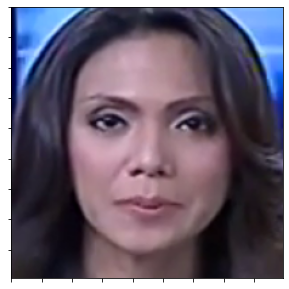

(224, 224, 3)


In [4]:
path = 'drive/My Drive/0135.png'
test_img = cv2.imread(path)
test_img = np.array(test_img)
test_img = cv2.resize(test_img,(224,224))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR) # not necessary (changes colour output)

# show
fig, ax = plt.subplots(figsize = (5, 5))
plt.imshow(test_img);
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()
print(test_img.shape)

# GridMask

Code is taken from https://www.kaggle.com/xiejialun/gridmask-data-augmentation-with-tensorflow/notebook

In [5]:
AugParams = {
    'd1' : int(224/5),
    'd2': int(224/2.5),
    'rotate' : 0,
    'ratio' : 0.5
}

def transform(image, inv_mat, image_shape):

    h, w, c = image_shape
    cx, cy = w//2, h//2

    new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
    new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
    new_zs = tf.ones([h*w], dtype=tf.int32)

    old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
    old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)

    clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
    clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
    clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)

    old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
    old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
    new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
    new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))

    old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
    new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
    rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
    rotated_image_channel = list()
    for i in range(c):
        vals = rotated_image_values[:,i]
        sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
        rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))

    return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):

    def get_rotation_mat_inv(angle):
          #transform to radian
        angle = math.pi * angle / 180

        cos_val = tf.math.cos(angle)
        sin_val = tf.math.sin(angle)
        one = tf.constant([1], tf.float32)
        zero = tf.constant([0], tf.float32)

        rot_mat_inv = tf.concat([cos_val, sin_val, zero,
                                     -sin_val, cos_val, zero,
                                     zero, zero, one], axis=0)
        rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])

        return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform(image, rot_mat_inv, image_shape)


def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):

    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges <0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges <0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask

def apply_GridMask(image, image_shape):
    mask = GridMask(image_shape[0],
                    image_shape[1],
                    AugParams['d1'],
                    AugParams['d2'],
                    AugParams['rotate'],
                    AugParams['ratio'])
    
    if image_shape[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)

    return image * tf.cast(mask, tf.uint8)

In [6]:
def GridMask_augmentation(image, prob = 0.5):
    '''With probability prob (inputted value, by default 0.5),
    augments an inputted image with GridMask'''
    if tf.random.uniform(shape=[], minval=0.0, maxval=1.0) <= prob:
        image = apply_GridMask(image, image.shape)
    return tf.cast(image, tf.uint8)

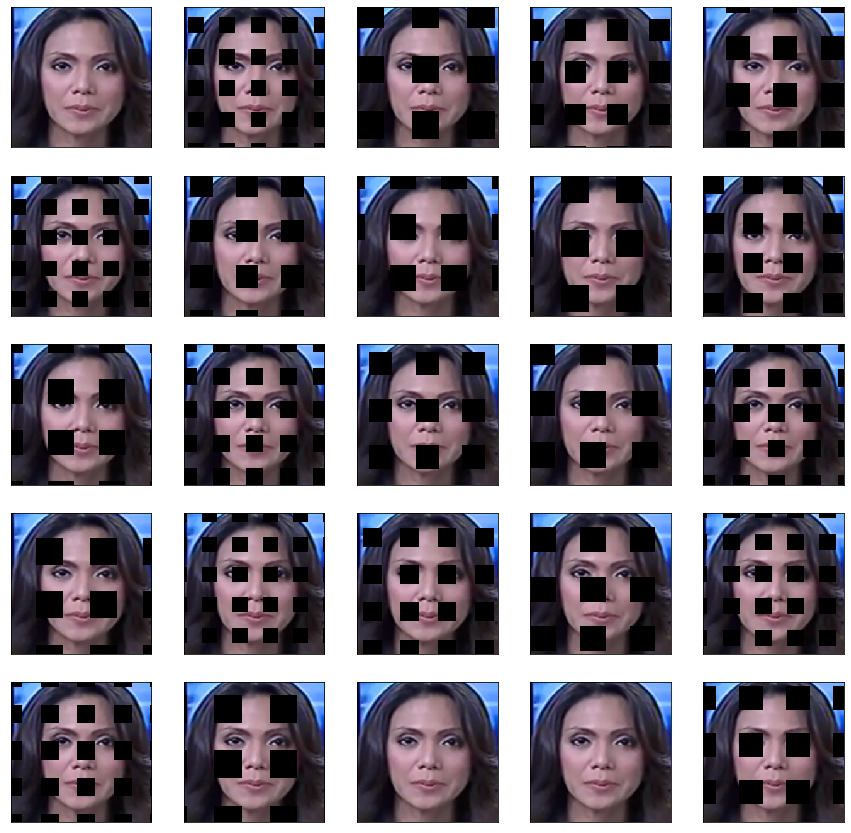

In [7]:
fig, axe = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        axe[i][j].imshow(GridMask_augmentation(test_img, 0.85), interpolation="nearest")
        axe[i][j].set_xticks([])
        axe[i][j].set_yticks([])

plt.show()

# GridMask Alternative

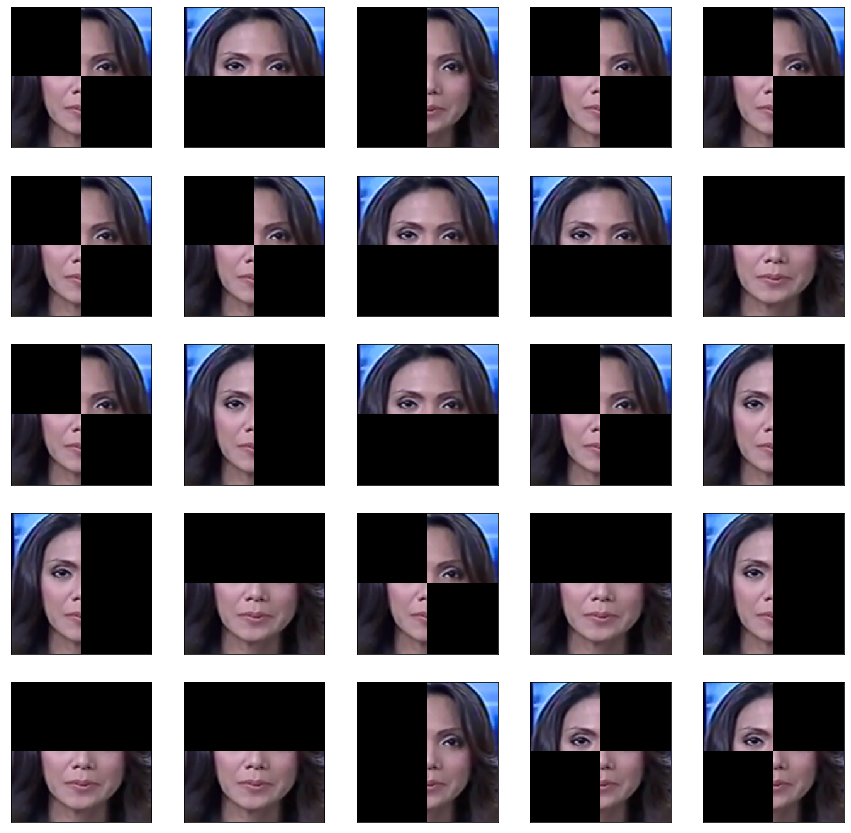

In [28]:
def alternative_GridMask_augmentation(image):
    
    import random
    from PIL import Image

    arr = np.array(image)
    n = n = random.uniform(0, 6)

    if 0 <= n and n <= 1: # cut top half
        arr[:arr.shape[0] // 2,:] = 0
    elif 1 < n and n <= 2: # cut bottom half
        arr[arr.shape[0] // 2 :,:] = 0
    elif 2 < n and n <= 3: # cut right half
        arr[:,arr.shape[1] // 2:] = 0
    elif 3 < n and n <= 4: # cut left half
        arr[:,:arr.shape[1] // 2] = 0
    elif 4 < n and n <= 5: # cut top left and bottom right quarters
        arr[:arr.shape[0] // 2 , :arr.shape[1] // 2] = 0
        arr[arr.shape[0] // 2:, arr.shape[0] // 2:] = 0
    elif 5 < n and n <= 6: # cut top right and bottom left quarters
        arr[:arr.shape[0] // 2 , arr.shape[0] // 2:] = 0
        arr[arr.shape[0] // 2:, :arr.shape[0] // 2] = 0

    return arr

def display_images_alternative_GridMask(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = alternative_GridMask_augmentation(image)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()

display_images_alternative_GridMask(test_img, 5, 15)

# Cut Facial Artifacts

In [9]:
face_landmarks_list = face_recognition.face_landmarks(test_img)
face_landmarks_dict = face_landmarks_list[0]

print(list(face_landmarks_dict.keys()))

# for key in face_landmarks_dict.keys()
    # print(key + ':')
    # print(face_landmarks_dict[key], '\n')

['chin', 'left_eyebrow', 'right_eyebrow', 'nose_bridge', 'nose_tip', 'left_eye', 'right_eye', 'top_lip', 'bottom_lip']


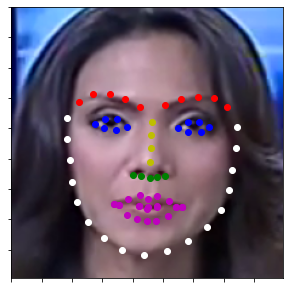

In [10]:
fig, ax = plt.subplots(figsize = (5, 5))
plt.imshow(test_img);
ax.set_xticklabels([])
ax.set_yticklabels([])

colour = ['w', 'r', 'r', 'y', 'g', 'b', 'b', 'm', 'm']

i = 0
for key in list(face_landmarks_dict.keys()):
    for point in face_landmarks_dict[key]:
        x, y = point
        plt.scatter(x, y, color = colour[i])
    i += 1

plt.show()

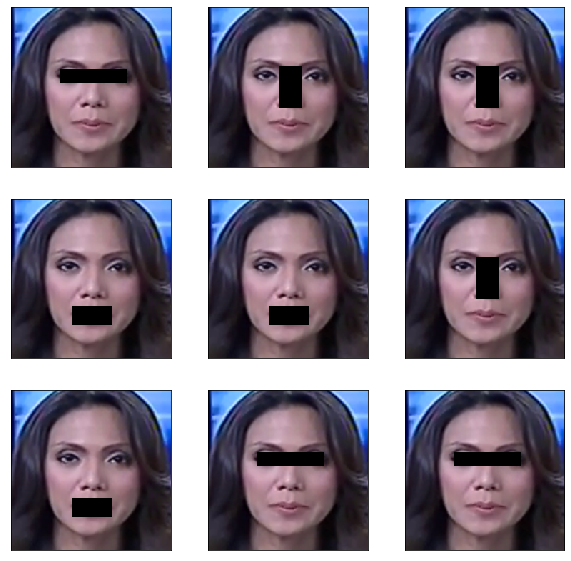

In [27]:
def facial_artifacts_cutout_augmentation(image):
    face_landmarks_list = face_recognition.face_landmarks(image)
    face_landmarks_dict = face_landmarks_list[0]
    arr = np.array(image)
    n = random.uniform(0, 3)

    if 0 <= n and n <= 1: # cut out mouth
        top_lip = list(face_landmarks_dict['top_lip'])
        bottom_lip = list(face_landmarks_dict['bottom_lip'])

        left_x = top_lip[0][0]
        right_x = top_lip[6][0]
        top_y = (top_lip[2][1] + top_lip[4][1]) //2
        bottom_y = bottom_lip[3][1]
        height = (bottom_y - top_y) * 1.25
        center_y = (top_y + bottom_y) // 2

        arr[int(center_y - height/2):int(center_y + height/2),
                left_x:right_x] = 0

    if 1 < n and n <= 2: # cut out nose
        left_eyebrow = list(face_landmarks_dict['left_eyebrow'])[4]
        right_eyebrow = list(face_landmarks_dict['right_eyebrow'])[0]
        nose_tip = list(face_landmarks_dict['nose_tip'])[2]

        width = (right_eyebrow[0] - left_eyebrow[0]) * 1.5
        center_x = (right_eyebrow[0] + left_eyebrow[0]) // 2

        arr[(left_eyebrow[1] + left_eyebrow[1]) //2:nose_tip[1],
                int(center_x - width/2):int(center_x + width/2)] = 0

    if 2 < n and n <= 3: # cut out eyes
        left_eye = list(face_landmarks_dict['left_eye'])
        right_eye = list(face_landmarks_dict['right_eye'])

        outer_left  = left_eye[0]
        outer_right = right_eye[3]
        top_left_y = (left_eye[1][1] + left_eye[2][1]) //2
        bottom_left_y = (left_eye[4][1] + left_eye[5][1]) //2

        top_right_y = (right_eye[1][1] + right_eye[2][1]) //2
        bottom_right_y = (right_eye[4][1] + right_eye[5][1]) //2
        
        top_y =  (top_left_y + top_right_y) //2
        bottom_y = (bottom_left_y + bottom_right_y) //2

        center_y = (top_y + bottom_y) // 2
        height = (bottom_y - top_y) * 2.5
        
        arr[int(center_y - height/2):int(center_y + height/2),
            outer_left[0]:outer_right[0]] = 0
    
    return Image.fromarray(arr)

def display_images_facial_artifacts(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = facial_artifacts_cutout_augmentation(image)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()

display_images_facial_artifacts(test_img, 3, 10)

# Cut Facial Artifacts Alternative

In [ ]:
# in progress
# idea: use facial mask technique to cut out mouth and nose properly instead of rectangles

# Cut Facial Mask

## Loading Functions

Face parser and all other related code between #-lines is from https://github.com/shaoanlu/face_toolbox_keras

In [16]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 2.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [15]:
# from models.parser import face_parser
###############################################################################################################
import numpy as np
import cv2
from pathlib import Path

#  from .BiSeNet.bisenet import BiSeNet_keras
###############################################################################################################
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(x, f, k, s=1, block_name="", layer_id="", use_activ=True):
    if k != 1:
        x = ZeroPadding2D(1)(x)
    x = Conv2D(f, k, strides=s, padding='valid', use_bias=False, name=block_name+".conv"+layer_id)(x)
    x = BatchNormalization(epsilon=1e-5, name=block_name+".bn"+layer_id)(x)
    x = Activation("relu")(x) if use_activ else x
    return x

def res_block_with_downsampling(x, f, block_name="cp.resnet.layerN"):
    skip = Conv2D(f, 1, strides=2, use_bias=False, name=block_name+".0.downsample.0")(x)
    skip = BatchNormalization(epsilon=1e-5, name=block_name+".0.downsample.1")(skip)
    x = conv_block(x, f, 3, s=2, block_name=block_name+".0", layer_id="1")
    x = conv_block(x, f, 3, block_name=block_name+".0", layer_id="2", use_activ=False)
    x = Add()([x, skip])
    x = Activation("relu")(x)
    
    skip = x
    x = conv_block(x, f, 3, block_name=block_name+".1", layer_id="1")
    x = conv_block(x, f, 3, block_name=block_name+".1", layer_id="2", use_activ=False)
    x = Add()([x, skip])
    x = Activation("relu")(x)
    return x

def attention_refinment_block(x, f, block_name="cp.arm16"):
    x = Conv2D(f, 3, padding='same', use_bias=False, name=block_name+".conv.conv")(x)
    x = BatchNormalization(epsilon=1e-5, name=block_name+".conv.bn")(x)
    x = Activation("relu")(x)
    
    attn = GlobalAveragePooling2D()(x)
    attn = Reshape((1,1,f))(attn)
    attn = Conv2D(f, 1, use_bias=False, name=block_name+".conv_atten")(attn)
    attn = BatchNormalization(epsilon=1e-5, name=block_name+".bn_atten")(attn)
    attn = Activation("sigmoid")(attn)
    x = Multiply()([x, attn])
    return x

def feature_fusion_block(x1, x2):
    x = Concatenate()([x1, x2])
    x = conv_block(x, 256, 1, block_name="ffm.convblk", layer_id="")    
    attn = GlobalAveragePooling2D()(x)
    attn = Reshape((1,1,256))(attn)
    attn = Conv2D(64, 1, use_bias=False, name="ffm.conv1")(attn)
    attn = Activation("relu")(attn)
    attn = Conv2D(256, 1, use_bias=False, name="ffm.conv2")(attn)
    feat_attn = Activation("sigmoid")(attn)
    attn = Multiply()([x, feat_attn])    
    x = Add()([x, attn])
    return x

def upsampling(x, shape, interpolation="nearest"):    
    return Lambda(lambda t: tf.image.resize(t, shape))(x)
    #if interpolation == "nearest":
        # return Lambda(lambda t: tf.image.resize_nearest_neighbor(t, shape, align_corners=True))(x)
        #return Lambda(lambda t: tf.image.resize(t, shape))(x)
    #elif interpolation == "bilinear":
        #return Lambda(lambda t: tf.image.resize_bilinear(t, shape, align_corners=True))(x)

def maxpool(x, k=3, s=2, pad=1):
    x = ZeroPadding2D(pad)(x)
    x = MaxPooling2D((k,k), strides=s)(x)
    return x
    
def BiSeNet_keras(input_resolution=512):
    inp = Input((input_resolution, input_resolution, 3))
    x = ZeroPadding2D(3)(inp)
    x = Conv2D(64, 7, strides=2, use_bias=False, name="cp.resnet.conv1")(x)
    x = BatchNormalization(epsilon=1e-5, name="cp.resnet.bn1")(x)
    x = Activation('relu')(x)
    x = maxpool(x)
    
    # layer1
    skip = x
    x = conv_block(x, 64, 3, block_name="cp.resnet.layer1.0", layer_id="1")
    x = conv_block(x, 64, 3, block_name="cp.resnet.layer1.0", layer_id="2", use_activ=False)
    x = Add()([x, skip])
    x = Activation("relu")(x)
    skip = x
    x = conv_block(x, 64, 3, block_name="cp.resnet.layer1.1", layer_id="1")
    x = conv_block(x, 64, 3, block_name="cp.resnet.layer1.1", layer_id="2", use_activ=False)
    x = Add()([x, skip])
    x = Activation("relu")(x)
    
    # layer2
    x = res_block_with_downsampling(x, 128, block_name="cp.resnet.layer2")
    feat8 = x
    
    # layer3
    x = res_block_with_downsampling(x, 256, block_name="cp.resnet.layer3")
    feat16 = x
    
    # ARM1
    feat16_arm = attention_refinment_block(feat16, 128, block_name="cp.arm16")
    
    # layer4
    x = res_block_with_downsampling(x, 512, block_name="cp.resnet.layer4")   
    feat32 = x 
    
    # ARM2 and conv_avg
    conv_avg = GlobalAveragePooling2D()(x)
    conv_avg = Reshape((1,1,512))(conv_avg)
    conv_avg = conv_block(conv_avg, 128, 1, block_name="cp.conv_avg", layer_id="")
    avg_up = upsampling(conv_avg, [input_resolution//32, input_resolution//32])
    feat32_arm = attention_refinment_block(x, 128, block_name="cp.arm32")
    feat32_sum = Add(name="feat32_sum")([feat32_arm, avg_up])
    feat32_up = upsampling(feat32_sum, [input_resolution//16, input_resolution//16])
    feat32_up = conv_block(feat32_up, 128, 3, block_name="cp.conv_head32", layer_id="")
    
    feat16_sum = Add(name="feat16_sum")([feat16_arm, feat32_up])
    feat16_up = upsampling(feat16_sum, [input_resolution//8, input_resolution//8])
    feat16_up = conv_block(feat16_up, 128, 3, block_name="cp.conv_head16", layer_id="")
    
    # FFM
    feat_sp, feat_cp8 = feat8, feat16_up
    feat_fuse = feature_fusion_block(feat_sp, feat_cp8)
    
    feat_out = conv_block(feat_fuse, 256, 3, block_name="conv_out.conv", layer_id="")
    feat_out = Conv2D(19, 1, strides=1, use_bias=False, name="conv_out.conv_out")(feat_out)
    feat_out = upsampling(feat_out, [input_resolution, input_resolution], interpolation="bilinear")
    # Ignore feat_out32 and feat_out16 since they are not used in inference phase
    
    return Model(inp, feat_out)
###############################################################################################################

class FaceParser():
    def __init__(self, path_bisenet_weights="drive/My Drive/BiSeNet_keras.h5", detector=None):
        self.parser_net = None
        self.detector = detector
    
        self.build_parser_net(path_bisenet_weights)
        
    def build_parser_net(self, path):
        parser_net = BiSeNet_keras()
        parser_net.load_weights(path)
        self.parser_net = parser_net
        
    def set_detector(self, detector):
        self.detector = detector
    
    def remove_detector(self):
        self.detector = None
    
    def parse_face(self, im, bounding_box=None, with_detection=False):
        orig_h, orig_w = im.shape[:2]
        
        # Detect/Crop face RoI
        if bounding_box == None:
            if with_detection:
                try:
                    self.detector.fd
                except:
                    raise NameError("Error occurs during face detection: \
                    detector not found in FaceParser.")
                bboxes = self.detector.fd.detect_face(im)
                faces = []
                for bbox in bboxes:
                    y0, x0, y1, x1, _ = bbox
                    x0, y0 = np.maximum(x0, 0), np.maximum(y0, 0)
                    x1, y1 = np.minimum(x1, orig_h), np.minimum(y1, orig_w)
                    x0, y0, x1, y1 = map(np.int32, [x0, y0, x1, y1])
                    faces.append(im[x0:x1, y0:y1, :])
            else:
                faces = [im]
        else:
            x0, y0, x1, y1 = bounding_box
            x0, y0 = np.maximum(x0, 0), np.maximum(y0, 0)
            x1, y1 = np.minimum(x1, orig_h), np.minimum(y1, orig_w)
            x0, y0, x1, y1 = map(np.int32, [x0, y0, x1, y1])
            faces = [im[x0:x1, y0:y1, :]]
        
        maps = []
        for face in faces:
            # Preprocess input face for parser networks
            orig_h, orig_w = face.shape[:2]
            inp = cv2.resize(face, (512,512))
            inp = self.normalize_input(inp)
            inp = inp[None, ...]

            # Parser networks forward pass
            # Do NOT use bilinear interp. which adds artifacts to the parsing map
            out = self.parser_net.predict([inp])[0]
            parsing_map = out.argmax(axis=-1)
            parsing_map = cv2.resize(
                parsing_map.astype(np.uint8), 
                (orig_w, orig_h), 
                interpolation=cv2.INTER_NEAREST)
            maps.append(parsing_map)
        return maps
        
    @staticmethod
    def normalize_input(x, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        # x should be RGB with range [0, 255]
        return ((x / 255) - mean)  / std
###############################################################################################################

In [13]:
# from utils.visualize import show_parsing_with_annos
###############################################################################################################
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

parsing_annos = [
    '0, background', '1, skin', '2, left eyebrow', '3, right eyebrow', 
    '4, left eye', '5, right eye', '6, glasses', '7, left ear', '8, right ear', '9, earings',
    '10, nose', '11, mouth', '12, upper lip', '13, lower lip', 
    '14, neck', '15, neck_l', '16, cloth', '17, hair', '18, hat'
]

# https://matplotlib.org/tutorials/colors/colormap-manipulation.html
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
def show_parsing_with_annos(data):
    fig, ax = plt.subplots(figsize=(8,8))
    #get discrete colormap
    cmap = plt.get_cmap('gist_ncar', len(parsing_annos))
    new_colors = cmap(np.linspace(0, 1, len(parsing_annos)))
    new_colors[0, :] = np.array([0, 0, 0, 1.])
    new_cmap = ListedColormap(new_colors)
    
    # set limits .5 outside true range
    mat = ax.matshow(data, cmap=new_cmap, vmin=-0.5, vmax=18.5)
    
    #tell the colorbar to tick at integers    
    cbar = fig.colorbar(mat, ticks=np.arange(0, len(parsing_annos)))
    cbar.ax.set_yticklabels(parsing_annos)
    plt.axis('off')
    fig.show()
###############################################################################################################

## Example

In [16]:
# prs = face_parser.FaceParser()
prs = FaceParser()

In [18]:
# im = cv2.imread('drive/My Drive/0135.png')[..., ::-1]
im = test_img
parsing_map = prs.parse_face(im, bounding_box=None, with_detection=False)

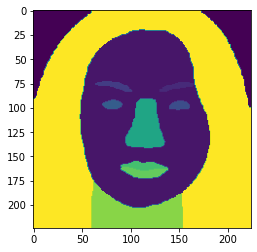

In [19]:
plt.imshow(parsing_map[0]);

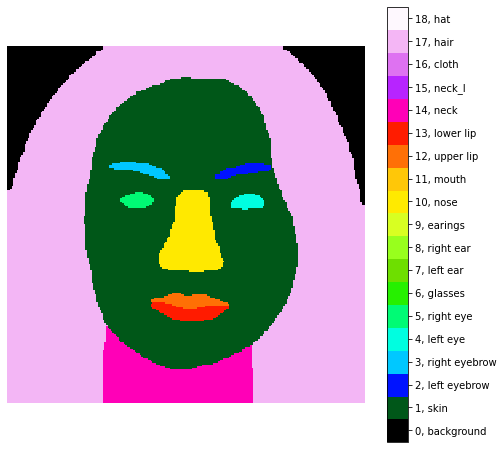

In [20]:
show_parsing_with_annos(parsing_map[0]);

Parsing map contains one element per face. Each of these elements is a multidimensional array (shape is img_height, img_width, 1) where each integer prepresents a pixel colour-coded based on the object (in range(0, 19).

In [21]:
print(type(parsing_map))
print(len(parsing_map))
print(len(parsing_map[0]))
print(len(parsing_map[0][0]))
print(parsing_map[0][0])

<class 'list'>
1
224
224
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


## Implementation

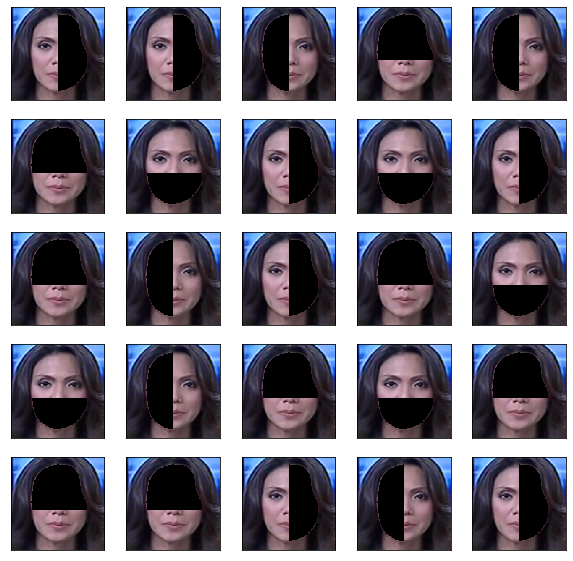

In [26]:
def facial_mask_cutout_augmentation(image):
    face_landmarks_list = face_recognition.face_landmarks(image)
    face_landmarks_dict = face_landmarks_list[0]
    arr = np.array(image)
    n = random.uniform(0, 4)

    if n <= 2: # cut vertically
        # nose_tip = list(face_landmarks_dict['nose_tip'])[2][1]
        nose_tip = list(face_landmarks_dict['nose_bridge'])[3][1]
        start_j = 0; end_j = arr.shape[1]
        # cut top half
        if n <= 1: start_i = 0; end_i = nose_tip
        # cut bottom half
        elif n > 1: start_i = nose_tip; end_i = arr.shape[0]

    elif n > 2: # cut horizontally
        nose_bridge = list(face_landmarks_dict['nose_bridge'])
        avg_y = int(sum([el[1] for el in nose_bridge])/ len(nose_bridge))
        start_i = 0; end_i = arr.shape[0]
        # cut left half
        if n <= 3: start_j = 0; end_j = avg_y
        # cut right half
        elif n > 3: start_j = avg_y; end_j = arr.shape[1]

    for i in range(start_i, end_i):
        for j in range(start_j, end_j):
            # parsing_map[face][y][x]
            pixel = parsing_map[0][i][j]
            if pixel in list(range(1,14)):
                arr[i][j] = [0, 0, 0]
    
    return Image.fromarray(arr)

def display_images_facial_mask(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = facial_mask_cutout_augmentation(image)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()

display_images_facial_mask(test_img, 5, 10)